# Replicability analysis

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np
import scipy.stats as stats
import scipy.spatial as spatial
import scanpy as sc

In [26]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [27]:
data_path = '/data_volume/memento/method_comparison/'

In [28]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'axes.labelsize': 'large'}
pylab.rcParams.update(params)

In [29]:
def concordance(x, y, log=False):
    nonnan = np.isfinite(x) & np.isfinite(y)
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

### Run memento on full and partial datasets

In [80]:
ifnb_df = pd.read_csv(data_path + 'mast/seurat_full.csv', index_col=0)
seurat_cells = ifnb_df.index.map(lambda x: '-'.join(x.split('.')))
seurat_genes = pd.read_csv(data_path + 'mast/seurat_genes.csv', index_col=0)['x']\
    .map(lambda x: '-'.join(x.split('.'))).tolist()


In [106]:
adata = sc.read('/data_volume/memento/demux/interferon.h5ad')
adata.var.index = adata.var.index.map(lambda x: '-'.join(x.split('.')))
adata.var.rename(index={'Y_RNA':'Y-RNA'}, inplace=True)
adata = adata[seurat_cells,  seurat_genes].copy().copy()
adata.obs['q'] = 0.1
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07,trim_percent=0.05)
adata_raw = adata.copy().copy()

In [107]:
memento.create_groups(adata, label_columns=['stim'])
memento.compute_1d_moments(adata, filter_genes=True)

meta_df = memento.get_groups(adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['stim']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])
# covariate = meta_df.iloc[:, -9:]

In [109]:
memento.ht_1d_moments(
    adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=50000, 
    verbose=1,
    num_cpus=90,
    resampling='bootstrap',
    approx=True)

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:    6.3s
[Parallel(n_jobs=90)]: Done 270 tasks      | elapsed:   10.9s
[Parallel(n_jobs=90)]: Done 620 tasks      | elapsed:   17.4s
[Parallel(n_jobs=90)]: Done 1070 tasks      | elapsed:   26.5s
[Parallel(n_jobs=90)]: Done 1620 tasks      | elapsed:   37.6s
[Parallel(n_jobs=90)]: Done 2032 out of 2032 | elapsed:   56.2s finished


In [110]:
adata_sample_1 = adata.copy().copy()
adata_sample_1 = adata_raw[np.random.choice(adata_raw.obs.index, 250, replace=False)].copy().copy()
# adata_sample_1 = sc.pp.subsample(adata_sample_1, n_obs=250, copy=True, random_state=None)
# memento.setup_memento(adata_sample_1, q_column='q', filter_mean_thresh=0.07,trim_percent=0.05)

memento.create_groups(adata_sample_1, label_columns=['stim'])
memento.compute_1d_moments(adata_sample_1, filter_genes=True)

meta_df = memento.get_groups(adata_sample_1)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['stim']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

# covariate = meta_df.iloc[:, -9:]
memento.ht_1d_moments(
    adata_sample_1, 
    treatment=treatment,
    covariate=covariate,
    num_boot=50000, 
    verbose=1,
    num_cpus=90,
    resampling='bootstrap',
    approx=True)

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:    0.6s
[Parallel(n_jobs=90)]: Done 270 tasks      | elapsed:    2.6s
[Parallel(n_jobs=90)]: Done 620 tasks      | elapsed:    5.5s
[Parallel(n_jobs=90)]: Done 1070 tasks      | elapsed:    9.3s
[Parallel(n_jobs=90)]: Done 1738 out of 1738 | elapsed:   15.1s finished


In [111]:
adata_sample_2 = adata.copy().copy()
adata_sample_2 = sc.pp.subsample(adata_sample_2, n_obs=250, copy=True, random_state=None)
memento.setup_memento(adata_sample_2, q_column='q', filter_mean_thresh=0.07,trim_percent=0.05)

memento.create_groups(adata_sample_2, label_columns=['stim'])
memento.compute_1d_moments(adata_sample_2, filter_genes=True)

meta_df = memento.get_groups(adata_sample_2)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=False)

treatment = meta_df[['stim']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

# covariate = meta_df.iloc[:, -9:]
memento.ht_1d_moments(
    adata_sample_2, 
    treatment=treatment,
    covariate=covariate,
    num_boot=50000, 
    verbose=1,
    num_cpus=14,
    resampling='bootstrap',
    approx=True)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.3s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    9.2s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   17.9s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   30.5s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   46.5s
[Parallel(n_jobs=14)]: Done 1567 out of 1567 | elapsed:   58.8s finished


In [112]:
adata.obs.to_csv(data_path + 'memento/meta_full.csv')
adata_sample_1.obs.to_csv(data_path + 'memento/meta_equal_rep_1.csv')
adata_sample_2.obs.to_csv(data_path + 'memento/meta_equal_rep_2.csv')

In [113]:
adata.write('/data_volume/memento/method_comparison/basics/full.h5ad')
adata_sample_1.write('/data_volume/memento/method_comparison/basics/partial_1.h5ad')
adata_sample_2.write('/data_volume/memento/method_comparison/basics/partial_2.h5ad')


... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical
... storing 'memento_group' as categorical
... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical
... storing 'memento_group' as categorical
... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical
... storing 'memento_group' as categorical


In [114]:
ht = memento.get_1d_ht_result(adata)
ht1 = memento.get_1d_ht_result(adata_sample_1)
ht2 = memento.get_1d_ht_result(adata_sample_2)

In [115]:
ht.to_csv(data_path + 'memento/memento_full.csv', index=False)
ht1.to_csv(data_path + 'memento/memento_equal_rep_1.csv', index=False)
ht2.to_csv(data_path + 'memento/memento_equal_rep_2.csv', index=False)

### Read the memento results

In [116]:
adata_sample_1 = sc.read('/data_volume/memento/method_comparison/basics/partial_1.h5ad')
adata = sc.read('/data_volume/memento/method_comparison/basics/full.h5ad')

### Run (in other notebook) and read MAST results

In [117]:
df1 = pd.read_csv(data_path + 'mast/MAST_equal_rep_1.csv', index_col=0)
df2 = pd.read_csv(data_path + 'mast/MAST_equal_rep_2.csv', index_col=0)

### Comparing to the full dataset - mean

In [118]:
full_df = pd.read_csv(data_path + 'mast/MAST_full_demux.csv', index_col=0)
full_df.columns =  ['gene', 'pval', 'coef', 'ci_hi', 'ci_io', 'fdr']

In [119]:
overlap_genes = list(set(adata.var.index) & set(adata_sample_1.var.index))

In [120]:
ctrl_data = adata[adata.obs['stim'] == 'ctrl', overlap_genes].X.toarray()
stim_data = adata[adata.obs['stim'] == 'stim',  overlap_genes].X.toarray()

ctrl_data /= ctrl_data.sum(axis=1).reshape(-1,1)
stim_data /= stim_data.sum(axis=1).reshape(-1,1)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [121]:
_, ttest_pv_full = stats.ttest_ind(ctrl_data, stim_data)
mwu_pv_full = np.array([stats.ranksums(ctrl_data[:, i], stim_data[:,i])[1] for i in range(ctrl_data.shape[1])])

In [122]:
sample_ctrl_data = adata_sample_1[adata_sample_1.obs['stim'] == 'ctrl', overlap_genes].X.toarray()
sample_stim_data = adata_sample_1[adata_sample_1.obs['stim'] == 'stim', overlap_genes].X.toarray()

sample_ctrl_data /= sample_ctrl_data.sum(axis=1).reshape(-1,1)
sample_stim_data /= sample_stim_data.sum(axis=1).reshape(-1,1)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [123]:
_, ttest_pv_sample = stats.ttest_ind(sample_ctrl_data, sample_stim_data)
mwu_pv_sample = np.array([stats.ranksums(sample_ctrl_data[:, i], sample_stim_data[:,i])[1] for i in range(sample_ctrl_data.shape[1])])

In [124]:
memento_ht_partial = pd.read_csv(data_path + 'memento/memento_equal_rep_{}.csv'.format(1), index_col=0)
memento_ht_full = pd.read_csv(data_path + 'memento/memento_full.csv'.format(1), index_col=0)

In [125]:
mast_ht_partial = pd.read_csv(data_path + 'mast/MAST_equal_rep_{}.csv'.format(1), index_col=0)
mast_ht_full = pd.read_csv(data_path + 'mast/MAST_full_demux.csv', index_col=0)

In [126]:
memento_joined = memento_ht_partial.merge(memento_ht_full, on='gene', suffixes=('_partial', '_full'))
mast_joined = mast_ht_partial.merge(mast_ht_full, on='primerid', suffixes=('_partial', '_full'))

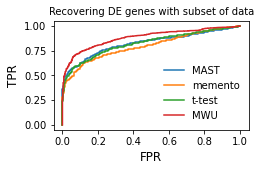

In [127]:
plt.figure(figsize=(3.5,2))
cutoff = 0.01

sig = (mast_joined['Pr(>Chisq)_full'] < cutoff).astype(int)
scores = 1-(mast_joined['Pr(>Chisq)_partial'])
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='MAST')

sig = (memento_joined['de_pval_full'] < cutoff).astype(int)
scores = 1-(memento_joined['de_pval_partial'])
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='memento')

sig = (ttest_pv_full < cutoff).astype(int)
# scores = np.random.random(size=len(sig))
scores = 1-ttest_pv_sample
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='t-test')

sig = (mwu_pv_full < cutoff).astype(int)
scores = 1-mwu_pv_sample
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='MWU')

plt.legend(frameon=False)

plt.title('Recovering DE genes with subset of data')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.savefig('de_recovery.pdf', bbox_inches='tight')